In [1]:
import sncosmo
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
# add the CSP band with a more common naming
band = sncosmo.get_bandpass("cspv9844")
sncosmo.register(band, 'cspv', force=True)

Relations from SNLS3 (Conley et al. 2011):

s (SiFTO) ≈ 0.98 + 0.091 * x1 (SALT2)

C (SiFTO) ≈ 1.04 * c (SALT2) + 0.001

In [3]:
def sifto_convert(x1_SALT, c_SALT):
    s = 0.98 + 0.091 * x1_SALT
    c = 1.04 * c_SALT + 0.001
    return s, c

In [4]:
# collect models
models_files = [file for file in Path("SIMSED.SNIa-91bg").glob("*.SED.gz")]
names = ["phase", "wave", "flux"]

for model_file in models_files:
    model_name = model_file.name.split(".")[0].replace("_", "-").lower()
    sed_df = pd.read_csv(model_file, names=names, sep="\\s+")

    phases = np.sort(sed_df.phase.unique())
    wavelengths = np.sort(sed_df.wave.unique()) 
    # pivot to 2D flux array (shape: n_phase x n_wave)
    flux_2d = sed_df.pivot(index='phase', columns='wave', values='flux').values
    # create new source
    source = sncosmo.TimeSeriesSource(phase=phases,
                                      wave=wavelengths,
                                      flux=flux_2d)
    # store the model
    sncosmo.registry.register(source, name=model_name, force=True)

In [5]:
names = ["dummy", "model", "s", "c"]
sed_info = pd.read_csv("SIMSED.SNIa-91bg/SED.INFO", skiprows=9, names=names, sep="\\s+")

In [38]:
from sed import SED
import matplotlib.pyplot as plt
from ztf_supernova import load_sn, ztf_df
from mangler import SEDMangler

ztfname = "ZTF18aahfgyz"
data, z, mwebv, t0 = load_sn(ztfname)

s, cs = sifto_convert(ztf_df.loc[ztfname].x1, ztf_df.loc[ztfname].c)
id_model = np.argmin(np.abs(sed_info.s.values - s) + np.abs(sed_info.c.values - cs))
source = sed_info.iloc[id_model].model.split(".")[0].replace("_", "-").lower()

sedmangler = SEDMangler(data, source, z, mwebv, phase_range=(-10, 88))
sedmangler.mangle_sed(wave_scale=10_000)

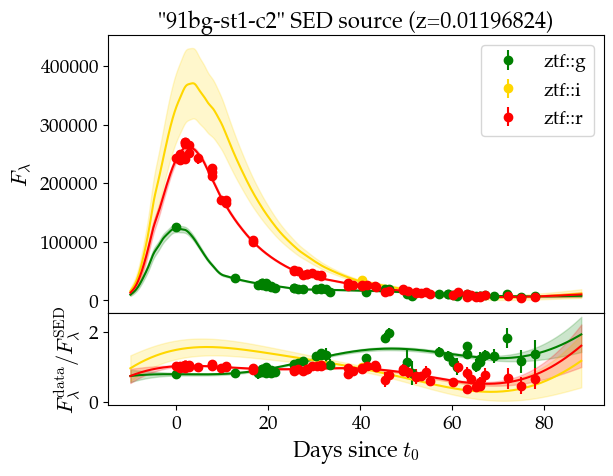

In [39]:
sedmangler.plot_fit()

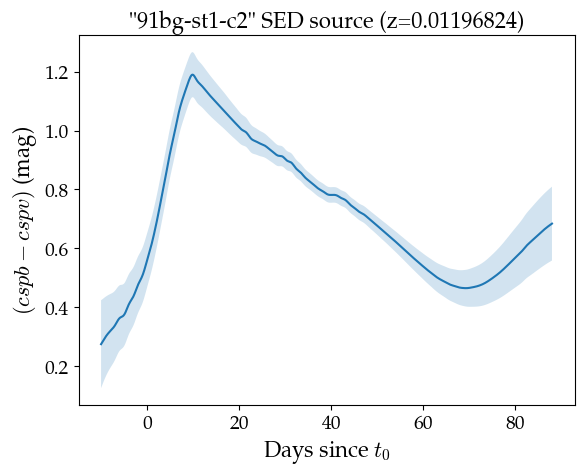

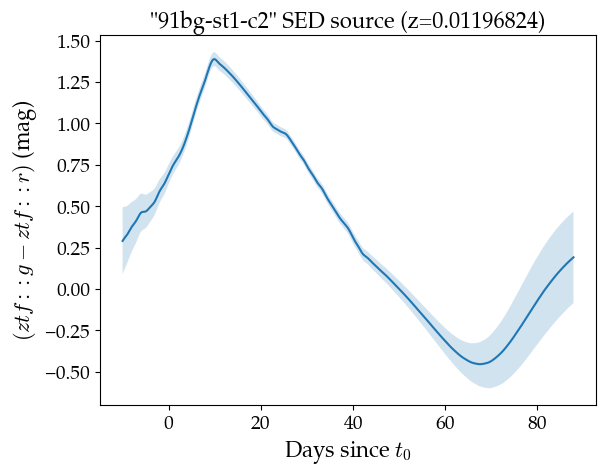

In [33]:
sedmangler.calculate_colour("cspb", "cspv")
sedmangler.calculate_colour("ztf::g", "ztf::r")